# Basic engine implementation

#### setup

In [1]:
import face_recognition, PIL.Image, PIL.ImageDraw,math
import numpy as np
import logging
import cv2
import platform
from matplotlib import pyplot as plt
from PIL import Image
import scipy.signal as sig

FORMAT = '[%(asctime)s] [%(levelname)s] [%(funcName)s] [%(lineno)d] : %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)

logging.info("Starting ...")
if platform.system() == "Windows":
    seperator = "\\"
else:
    seperator = "/"

dir = "perry-all-2"
# should be a parameter of the engine
dataset_location = ".." + seperator + "dataset" + seperator + "good_sync" + seperator
specific_dir = dir
video_location = dataset_location + specific_dir + seperator + "test.mp4"
video_location = "test2.mp4"

[2021-04-11 08:51:10,362] [INFO] [<module>] [13] : Starting ...


## running evm pre-processing

In [2]:
%run ./evm_preprocessing.ipynb
#video_location = dataset_location + specific_dir + seperator + "out.avi"
video_location="out2.avi"

[2021-04-11 08:51:10,523] [INFO] [<module>] [4] : Starting ...
[2021-04-11 08:51:10,524] [INFO] [<module>] [25] : libpath:/home/eyalgolan/PycharmProjects/KOIOS/venv/lib/python3.8/site-packages/wrapConv.cpython-38-x86_64-linux-gnu.so
[2021-04-11 08:51:10,562] [INFO] [amplify_spatial_Gdown_temporal_ideal] [21] : Spatial filtering...
[2021-04-11 08:52:05,994] [INFO] [amplify_spatial_Gdown_temporal_ideal] [23] : Finished
[2021-04-11 08:52:05,995] [INFO] [amplify_spatial_Gdown_temporal_ideal] [25] : Temporal filtering...
[2021-04-11 08:52:07,357] [INFO] [amplify_spatial_Gdown_temporal_ideal] [27] : Finished
[2021-04-11 08:52:07,384] [INFO] [amplify_spatial_Gdown_temporal_ideal] [34] : Rendering...
[2021-04-11 08:53:15,263] [INFO] [amplify_spatial_Gdown_temporal_ideal] [52] : Finished


#### Detecting the face landmarks and parsing the ROI

In [3]:
def parse_roi(frame):
    # image = face_recognition.load_image_file(frame) # read image.
    face_locations = face_recognition.face_locations(frame,model = 'hog') # detects all the faces in image
    face_landmarks_list = face_recognition.face_landmarks(image)
    
    # iterate through all the faces.
    for face_location in face_locations:
        img = PIL.Image.fromarray(frame)
        top,right,bottom,left = face_location # extract all face square points.
        diff = math.floor((top - bottom) * 0.15) # 20 percent of the face len (toadd eyebrow top point).
        
        # finding the forehead
        try:
            right_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['right_eyebrow']) # right eyebrow points.
        except:
            return None
        right_eyebrow_landmarks.sort(axis=0)
        rightest_point = right_eyebrow_landmarks[-1] # The most right point of the ROI(according to x).
        top_right_eyebrow = right_eyebrow_landmarks.min(axis = 0)[1]
        try:
            left_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['left_eyebrow'])
        except:
            return None
        left_eyebrow_landmarks.sort(axis=0)
        leftest_point = left_eyebrow_landmarks[0] # the most left point of ROI.(according to x)
        top_left_eyebrow = left_eyebrow_landmarks.min(axis = 0)[1]
        bottom = min(top_right_eyebrow,top_left_eyebrow).item(0) # bottom point of the forehead.
        bottom = bottom - (0.05 * bottom) # improve bottom location by 2 percent.
        forehead = img.crop((leftest_point[0], leftest_point[1]+diff, rightest_point[0],bottom+10)) # adding diff to top to make the forehead bigger.

        # finding the second ROI:
        try:
            upper_mouth = np.asarray(face_landmarks_list[0]['top_lip']) # top_lip landmarks
        except:
            return None
        upper_mouth_min = upper_mouth.min(axis = 0)[1] # The  top - lip upper point.
        try:
            upper_nose = np.asarray(face_landmarks_list[0]['nose_bridge'])
        except:
            return None
        upper_nose_min = upper_nose.min(axis = 0)[1]  # noise bridge upper point.
        upper_nose_min += upper_mouth_min * 0.1 # improving the noise bridge upper point.
        nose_to_upper_lip = img.crop((leftest_point[0], upper_nose_min, rightest_point[0], upper_mouth_min))

        return forehead, nose_to_upper_lip
    return None # in case of which no face was detected

### Check for bad frames
##### R > 95 and G > 40 and B > 20 and R > G and R > B
##### Based on https://arxiv.org/ftp/arxiv/papers/1708/1708.02694.pdf page 5

In [4]:
red_min_val = 95
green_min_val = 40
blue_min_val = 20
red_green_max_diff = 15
def good_frame(blue, green, red):
    if red <= red_min_val:
        logging.warning("bad frame detected, reason: red > red_min_val")
        return False
    if green <= green_min_val:
        logging.warning("bad frame detected, reason: green > green_min_val")
        return False
    if blue <= blue_min_val:
        logging.warning("bad frame detected, reason: blue > blue_min_val")
        return False
    if red <= green:
        logging.warning("bad frame detected, reason: red > green")
        return False
    if red <= blue:
        logging.warning("bad frame detected, reason: red > blue")
        return False
    if abs(red - green) <= red_green_max_diff:
        logging.warning("bad frame detected, reason: abs(red - green) > red_green_max_diff")
        return False

    return True

In [5]:
def get_new_frame(vidcap):
    success, next_image = vidcap.read()
    return success, next_image

#### Plotting RGB arrays results

In [6]:
def plot_result(greens, reds, blues, x_value, title=""):
    logging.info("Plotting results ..." + title)
    plt.figure(figsize=(6, 5))
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.subplot(3, 1, 1)
    plt.plot(x_value, greens, color="green")
    plt.subplot(3, 1, 2)
    plt.plot(x_value, reds, color="red")
    plt.subplot(3, 1, 3)
    plt.plot(x_value, blues, color="blue")
    plt.show()
    logging.info("Showing result")

#### Filtering:

In [7]:
def filter_channel(channel,fs):
    """
    This method apply filter on a channel between 0.75HZ to 4HZ.
    :param channel: Is a signal to apply the filter to.
    :param fs: Is the sampling rate of channel.
    :return: The filtered channel.
    """
    bh, ah = sig.butter(4, 0.75 / (fs / 2), 'highpass')
    bl, al = sig.butter(4, 4 / (fs / 2), 'lowpass')
    channel = sig.filtfilt(bh, ah, channel) # applying the filter coefficient on the sig
    #channel = np.absolute(channel)
    channel_after_filter = sig.filtfilt(bl, al, channel) # applying the filter coefficient on the sig
    return channel_after_filter

#### Getting RGB values from a frame and adding them to arrays

In [8]:
def parse_RGB(roi, color_sig):
    """
    Parses an image to its RGB channels
    :param image: the image to be parsed
    :param vidcap:
    :param greens: array containing green channel values
    :param blues: array containing blue channel values
    :param reds: array containing red channel values
    :param frame_number - is the number of the frame of the video.
    :return: a flag indicating if there is a next image, and the next image
    """
#     plt.imshow(roi)
#     plt.show()
    try:
        roi = cv2.cvtColor(roi, cv2.COLOR_RGB2BGR)
    except:
        return False, color_sig
    new_blue,new_green,new_red = cv2.split(roi)
    b_mean,g_mean,r_mean = np.mean(new_blue),np.mean(new_green),np.mean(new_red)
    if good_frame(b_mean,g_mean,r_mean):
        color_channels = roi.reshape(-1, roi.shape[-1])
        avg_color = color_channels.mean(axis=0)
        color_sig.append(avg_color)
        return True, color_sig
    return False, color_sig

#### Main loop - going over all the frames of the video

In [9]:
color_sig = []
heart_rates = []
good_frame_number = 0
total_frame_number = 0

# Parsing video:
logging.info("Working on video " + video_location)
vidcap = cv2.VideoCapture(video_location)
success, image = vidcap.read()
fps = vidcap.get(cv2.CAP_PROP_FPS) # fs == sampling rate
round_fps = np.round(fps)
number_of_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
logging.info("Parsing images ...")
while success:
    logging.info("parsing frame " + str(total_frame_number) + "/" + str(number_of_frames))
    rois = parse_roi(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # build image ROI (rois is a tuple contains two regions)
    if rois is not None : 
        roi = np.asarray(rois[0]) # Just the forehead
        is_good_frame,color_sig = parse_RGB(roi, color_sig)
        if is_good_frame:
            good_frame_number += 1
    total_frame_number += 1
    success, image = get_new_frame(vidcap)

[2021-04-11 08:53:15,483] [INFO] [<module>] [7] : Working on video out2.avi
[2021-04-11 08:53:15,494] [INFO] [<module>] [13] : Parsing images ...
[2021-04-11 08:53:15,495] [INFO] [<module>] [15] : parsing frame 0/1017.0
[2021-04-11 08:53:16,570] [INFO] [<module>] [15] : parsing frame 1/1017.0
[2021-04-11 08:53:17,637] [INFO] [<module>] [15] : parsing frame 2/1017.0
[2021-04-11 08:53:18,670] [INFO] [<module>] [15] : parsing frame 3/1017.0
[2021-04-11 08:53:19,704] [INFO] [<module>] [15] : parsing frame 4/1017.0
[2021-04-11 08:53:20,762] [INFO] [<module>] [15] : parsing frame 5/1017.0
[2021-04-11 08:53:21,808] [INFO] [<module>] [15] : parsing frame 6/1017.0
[2021-04-11 08:53:22,848] [INFO] [<module>] [15] : parsing frame 7/1017.0
[2021-04-11 08:53:23,892] [INFO] [<module>] [15] : parsing frame 8/1017.0
[2021-04-11 08:53:24,952] [INFO] [<module>] [15] : parsing frame 9/1017.0
[2021-04-11 08:53:26,010] [INFO] [<module>] [15] : parsing frame 10/1017.0
[2021-04-11 08:53:27,077] [INFO] [<modu

[2021-04-11 08:55:09,241] [INFO] [<module>] [15] : parsing frame 108/1017.0
[2021-04-11 08:55:10,279] [INFO] [<module>] [15] : parsing frame 109/1017.0
[2021-04-11 08:55:11,333] [INFO] [<module>] [15] : parsing frame 110/1017.0
[2021-04-11 08:55:12,373] [INFO] [<module>] [15] : parsing frame 111/1017.0
[2021-04-11 08:55:13,416] [INFO] [<module>] [15] : parsing frame 112/1017.0
[2021-04-11 08:55:14,454] [INFO] [<module>] [15] : parsing frame 113/1017.0
[2021-04-11 08:55:15,489] [INFO] [<module>] [15] : parsing frame 114/1017.0
[2021-04-11 08:55:16,527] [INFO] [<module>] [15] : parsing frame 115/1017.0
[2021-04-11 08:55:17,583] [INFO] [<module>] [15] : parsing frame 116/1017.0
[2021-04-11 08:55:18,616] [INFO] [<module>] [15] : parsing frame 117/1017.0
[2021-04-11 08:55:19,662] [INFO] [<module>] [15] : parsing frame 118/1017.0
[2021-04-11 08:55:20,692] [INFO] [<module>] [15] : parsing frame 119/1017.0
[2021-04-11 08:55:21,728] [INFO] [<module>] [15] : parsing frame 120/1017.0
[2021-04-11 

[2021-04-11 08:57:02,249] [INFO] [<module>] [15] : parsing frame 216/1017.0
[2021-04-11 08:57:03,334] [INFO] [<module>] [15] : parsing frame 217/1017.0
[2021-04-11 08:57:04,382] [INFO] [<module>] [15] : parsing frame 218/1017.0
[2021-04-11 08:57:05,414] [INFO] [<module>] [15] : parsing frame 219/1017.0
[2021-04-11 08:57:06,454] [INFO] [<module>] [15] : parsing frame 220/1017.0
[2021-04-11 08:57:07,748] [INFO] [<module>] [15] : parsing frame 221/1017.0
[2021-04-11 08:57:09,027] [INFO] [<module>] [15] : parsing frame 222/1017.0
[2021-04-11 08:57:10,151] [INFO] [<module>] [15] : parsing frame 223/1017.0
[2021-04-11 08:57:11,262] [INFO] [<module>] [15] : parsing frame 224/1017.0
[2021-04-11 08:57:12,450] [INFO] [<module>] [15] : parsing frame 225/1017.0
[2021-04-11 08:57:13,630] [INFO] [<module>] [15] : parsing frame 226/1017.0
[2021-04-11 08:57:14,752] [INFO] [<module>] [15] : parsing frame 227/1017.0
[2021-04-11 08:57:15,839] [INFO] [<module>] [15] : parsing frame 228/1017.0
[2021-04-11 

[2021-04-11 08:59:06,517] [INFO] [<module>] [15] : parsing frame 324/1017.0
[2021-04-11 08:59:07,717] [INFO] [<module>] [15] : parsing frame 325/1017.0
[2021-04-11 08:59:08,846] [INFO] [<module>] [15] : parsing frame 326/1017.0
[2021-04-11 08:59:10,020] [INFO] [<module>] [15] : parsing frame 327/1017.0
[2021-04-11 08:59:11,122] [INFO] [<module>] [15] : parsing frame 328/1017.0
[2021-04-11 08:59:12,213] [INFO] [<module>] [15] : parsing frame 329/1017.0
[2021-04-11 08:59:13,390] [INFO] [<module>] [15] : parsing frame 330/1017.0
[2021-04-11 08:59:14,491] [INFO] [<module>] [15] : parsing frame 331/1017.0
[2021-04-11 08:59:15,623] [INFO] [<module>] [15] : parsing frame 332/1017.0
[2021-04-11 08:59:16,772] [INFO] [<module>] [15] : parsing frame 333/1017.0
[2021-04-11 08:59:17,927] [INFO] [<module>] [15] : parsing frame 334/1017.0
[2021-04-11 08:59:19,079] [INFO] [<module>] [15] : parsing frame 335/1017.0
[2021-04-11 08:59:20,311] [INFO] [<module>] [15] : parsing frame 336/1017.0
[2021-04-11 

[2021-04-11 09:01:08,651] [INFO] [<module>] [15] : parsing frame 432/1017.0
[2021-04-11 09:01:09,695] [INFO] [<module>] [15] : parsing frame 433/1017.0
[2021-04-11 09:01:10,747] [INFO] [<module>] [15] : parsing frame 434/1017.0
[2021-04-11 09:01:11,792] [INFO] [<module>] [15] : parsing frame 435/1017.0
[2021-04-11 09:01:12,887] [INFO] [<module>] [15] : parsing frame 436/1017.0
[2021-04-11 09:01:14,031] [INFO] [<module>] [15] : parsing frame 437/1017.0
[2021-04-11 09:01:15,188] [INFO] [<module>] [15] : parsing frame 438/1017.0
[2021-04-11 09:01:16,246] [INFO] [<module>] [15] : parsing frame 439/1017.0
[2021-04-11 09:01:17,327] [INFO] [<module>] [15] : parsing frame 440/1017.0
[2021-04-11 09:01:18,441] [INFO] [<module>] [15] : parsing frame 441/1017.0
[2021-04-11 09:01:19,493] [INFO] [<module>] [15] : parsing frame 442/1017.0
[2021-04-11 09:01:20,540] [INFO] [<module>] [15] : parsing frame 443/1017.0
[2021-04-11 09:01:21,613] [INFO] [<module>] [15] : parsing frame 444/1017.0
[2021-04-11 

[2021-04-11 09:03:09,922] [INFO] [<module>] [15] : parsing frame 540/1017.0
[2021-04-11 09:03:11,022] [INFO] [<module>] [15] : parsing frame 541/1017.0
[2021-04-11 09:03:12,116] [INFO] [<module>] [15] : parsing frame 542/1017.0
[2021-04-11 09:03:13,192] [INFO] [<module>] [15] : parsing frame 543/1017.0
[2021-04-11 09:03:14,273] [INFO] [<module>] [15] : parsing frame 544/1017.0
[2021-04-11 09:03:15,421] [INFO] [<module>] [15] : parsing frame 545/1017.0
[2021-04-11 09:03:16,568] [INFO] [<module>] [15] : parsing frame 546/1017.0
[2021-04-11 09:03:17,710] [INFO] [<module>] [15] : parsing frame 547/1017.0
[2021-04-11 09:03:18,856] [INFO] [<module>] [15] : parsing frame 548/1017.0
[2021-04-11 09:03:20,009] [INFO] [<module>] [15] : parsing frame 549/1017.0
[2021-04-11 09:03:21,223] [INFO] [<module>] [15] : parsing frame 550/1017.0
[2021-04-11 09:03:22,389] [INFO] [<module>] [15] : parsing frame 551/1017.0
[2021-04-11 09:03:23,497] [INFO] [<module>] [15] : parsing frame 552/1017.0
[2021-04-11 

[2021-04-11 09:05:14,369] [INFO] [<module>] [15] : parsing frame 648/1017.0
[2021-04-11 09:05:15,486] [INFO] [<module>] [15] : parsing frame 649/1017.0
[2021-04-11 09:05:16,633] [INFO] [<module>] [15] : parsing frame 650/1017.0
[2021-04-11 09:05:17,749] [INFO] [<module>] [15] : parsing frame 651/1017.0
[2021-04-11 09:05:18,890] [INFO] [<module>] [15] : parsing frame 652/1017.0
[2021-04-11 09:05:20,020] [INFO] [<module>] [15] : parsing frame 653/1017.0
[2021-04-11 09:05:21,113] [INFO] [<module>] [15] : parsing frame 654/1017.0
[2021-04-11 09:05:22,210] [INFO] [<module>] [15] : parsing frame 655/1017.0
[2021-04-11 09:05:23,310] [INFO] [<module>] [15] : parsing frame 656/1017.0
[2021-04-11 09:05:24,407] [INFO] [<module>] [15] : parsing frame 657/1017.0
[2021-04-11 09:05:25,510] [INFO] [<module>] [15] : parsing frame 658/1017.0
[2021-04-11 09:05:26,673] [INFO] [<module>] [15] : parsing frame 659/1017.0
[2021-04-11 09:05:27,815] [INFO] [<module>] [15] : parsing frame 660/1017.0
[2021-04-11 

[2021-04-11 09:07:18,430] [INFO] [<module>] [15] : parsing frame 756/1017.0
[2021-04-11 09:07:19,681] [INFO] [<module>] [15] : parsing frame 757/1017.0
[2021-04-11 09:07:20,823] [INFO] [<module>] [15] : parsing frame 758/1017.0
[2021-04-11 09:07:21,996] [INFO] [<module>] [15] : parsing frame 759/1017.0
[2021-04-11 09:07:23,196] [INFO] [<module>] [15] : parsing frame 760/1017.0
[2021-04-11 09:07:24,327] [INFO] [<module>] [15] : parsing frame 761/1017.0
[2021-04-11 09:07:25,440] [INFO] [<module>] [15] : parsing frame 762/1017.0
[2021-04-11 09:07:26,641] [INFO] [<module>] [15] : parsing frame 763/1017.0
[2021-04-11 09:07:27,961] [INFO] [<module>] [15] : parsing frame 764/1017.0
[2021-04-11 09:07:29,233] [INFO] [<module>] [15] : parsing frame 765/1017.0
[2021-04-11 09:07:30,401] [INFO] [<module>] [15] : parsing frame 766/1017.0
[2021-04-11 09:07:31,545] [INFO] [<module>] [15] : parsing frame 767/1017.0
[2021-04-11 09:07:32,686] [INFO] [<module>] [15] : parsing frame 768/1017.0
[2021-04-11 

[2021-04-11 09:09:21,126] [INFO] [<module>] [15] : parsing frame 864/1017.0
[2021-04-11 09:09:22,225] [INFO] [<module>] [15] : parsing frame 865/1017.0
[2021-04-11 09:09:23,321] [INFO] [<module>] [15] : parsing frame 866/1017.0
[2021-04-11 09:09:24,419] [INFO] [<module>] [15] : parsing frame 867/1017.0
[2021-04-11 09:09:25,508] [INFO] [<module>] [15] : parsing frame 868/1017.0
[2021-04-11 09:09:26,593] [INFO] [<module>] [15] : parsing frame 869/1017.0
[2021-04-11 09:09:27,721] [INFO] [<module>] [15] : parsing frame 870/1017.0
[2021-04-11 09:09:28,849] [INFO] [<module>] [15] : parsing frame 871/1017.0
[2021-04-11 09:09:29,992] [INFO] [<module>] [15] : parsing frame 872/1017.0
[2021-04-11 09:09:31,124] [INFO] [<module>] [15] : parsing frame 873/1017.0
[2021-04-11 09:09:32,256] [INFO] [<module>] [15] : parsing frame 874/1017.0
[2021-04-11 09:09:33,434] [INFO] [<module>] [15] : parsing frame 875/1017.0
[2021-04-11 09:09:34,736] [INFO] [<module>] [15] : parsing frame 876/1017.0
[2021-04-11 

[2021-04-11 09:11:25,159] [INFO] [<module>] [15] : parsing frame 972/1017.0
[2021-04-11 09:11:26,429] [INFO] [<module>] [15] : parsing frame 973/1017.0
[2021-04-11 09:11:27,774] [INFO] [<module>] [15] : parsing frame 974/1017.0
[2021-04-11 09:11:29,336] [INFO] [<module>] [15] : parsing frame 975/1017.0
[2021-04-11 09:11:30,878] [INFO] [<module>] [15] : parsing frame 976/1017.0
[2021-04-11 09:11:32,402] [INFO] [<module>] [15] : parsing frame 977/1017.0
[2021-04-11 09:11:34,097] [INFO] [<module>] [15] : parsing frame 978/1017.0
[2021-04-11 09:11:35,672] [INFO] [<module>] [15] : parsing frame 979/1017.0
[2021-04-11 09:11:37,082] [INFO] [<module>] [15] : parsing frame 980/1017.0
[2021-04-11 09:11:38,604] [INFO] [<module>] [15] : parsing frame 981/1017.0
[2021-04-11 09:11:40,372] [INFO] [<module>] [15] : parsing frame 982/1017.0
[2021-04-11 09:11:41,808] [INFO] [<module>] [15] : parsing frame 983/1017.0
[2021-04-11 09:11:43,162] [INFO] [<module>] [15] : parsing frame 984/1017.0
[2021-04-11 

In [19]:
def print_results(window_sig, window, xlabel, ylabel, change_range):
    fig = plt.figure()
    ax = fig.subplots()
    
    # changing the size of window_sig to match window
    removed_from_sig = 0
    while len(window_sig) > len(window):
        window_sig = window_sig[: -1]
        removed_from_sig += 1
    #logging.info("Removed results from signal to match window: " + str(removed_from_sig))
    
    ax.plot(window_sig,window,color ='green')
    if change_range:
        plt.xlim([0, 5])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale('linear')
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    plt.show()

def find_hr_in_window(green, window_start, round_fps, window_id, window_size):
    round_fps = int(round_fps)
    if window_start + round_fps * window_size > len(green):
        window = green[window_start : ]
    else:
        window = green[window_start : window_start + round_fps * window_size]
    window_sig = np.arange(window.size/round_fps,step= (1/30))

    print_results(window_sig, window, 'X-axis', 'Y-axis', False)

    window = window - np.mean(window)
    window = window / np.std(window)
    print_results(window_sig, window, 'X-axis', 'Y-axis', False)

    g = filter_channel(window,round_fps)
    print_results(window_sig, g, 'X-axis', 'Y-axis', False)

    f, Pxx_den = sig.periodogram(g, round_fps)

    print_results(f, Pxx_den, 'frequency [Hz]', 'PSD [V**2/Hz]', True)
    # plt.semilogy(f, Pxx_den)
    # plt.ylim([1e-7, 1e2])
    # plt.xlabel('frequency [Hz]')
    # plt.ylabel('PSD [V**2/Hz]')
    # plt.show()


    max_val = Pxx_den.argmax()
    logging.info("Heart rate of window " + str(window_id) +
                 ": " + str(f[max_val]))

[2021-04-11 09:36:38,995] [INFO] [print_results] [8] : Removed results from signal to match window: 0


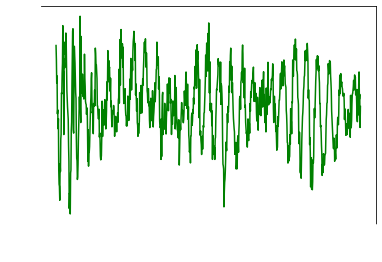

[2021-04-11 09:36:39,171] [INFO] [print_results] [8] : Removed results from signal to match window: 0


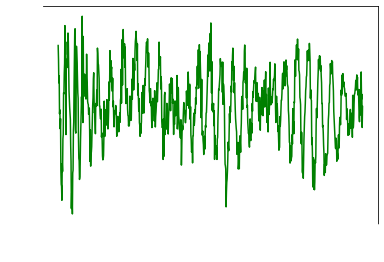

[2021-04-11 09:36:39,347] [INFO] [print_results] [8] : Removed results from signal to match window: 0


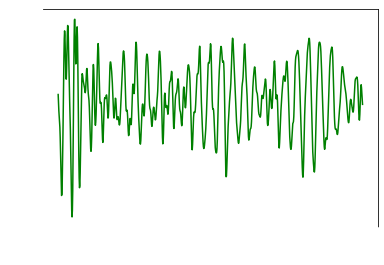

[2021-04-11 09:36:39,516] [INFO] [print_results] [8] : Removed results from signal to match window: 0


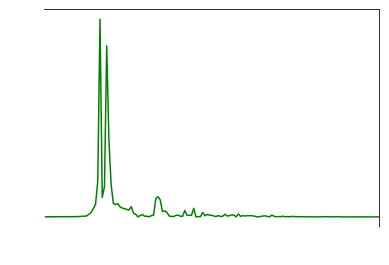

[2021-04-11 09:36:39,644] [INFO] [find_hr_in_window] [52] : Heart rate of window 0: 0.8333333333333334
[2021-04-11 09:36:39,671] [INFO] [print_results] [8] : Removed results from signal to match window: 1


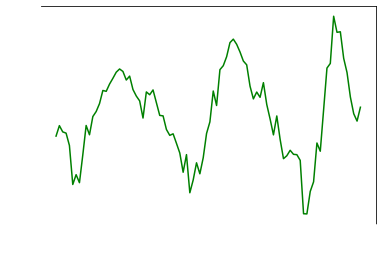

[2021-04-11 09:36:39,834] [INFO] [print_results] [8] : Removed results from signal to match window: 1


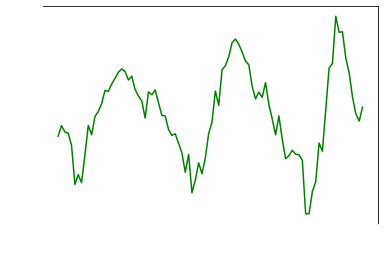

[2021-04-11 09:36:40,009] [INFO] [print_results] [8] : Removed results from signal to match window: 1


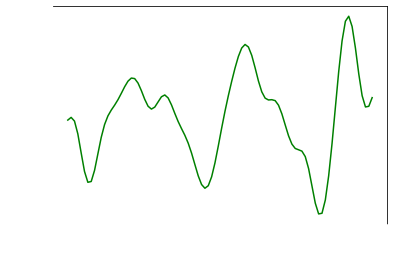

[2021-04-11 09:36:40,183] [INFO] [print_results] [8] : Removed results from signal to match window: 0


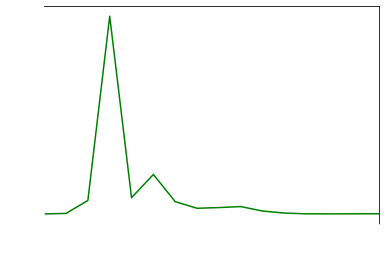

[2021-04-11 09:36:40,314] [INFO] [find_hr_in_window] [52] : Heart rate of window 2: 0.9782608695652174


In [20]:
color_sig_array = np.asarray(color_sig)
red = color_sig_array[:,0]
green = color_sig_array[:,1]
blue = color_sig_array[:,2]

window_start = 0
window_size = 30
window_id = 0
limit = good_frame_number - int(round_fps) * window_size
while window_start < limit :
    find_hr_in_window(green, window_start, round_fps, window_id, window_size)
    window_start += int(round_fps) * window_size
    window_id += 1
if window_start < good_frame_number:
    window_id += 1
    find_hr_in_window(green, window_start, round_fps, window_id, good_frame_number - window_start)

In [ ]:
a = Pxx_den
ind = np.argsort(a)
max_ind = ind[-5:]
print(f[max_ind])
print("HR for this video is: " +str(f[max_ind].mean()))

In [ ]:
if good_frame_number != greens.size: # TO BE REVIEW BY EYAL, POSSIBLE BUG FIX HERE!
    frame_number = greens.size
axis = np.arange((good_frame_number / round_fps), step=(1 / 30)) # axis is Time
plot_result(greens, reds, blues, axis, "All 3 channels") # original signals
# apply filtering on all the channels:
green_buttered = filter_channel(greens,round_fps)
red_buttered = filter_channel(reds,round_fps)
blue_buttered = filter_channel(blues,round_fps)
# plotting the channels after apllying the filter
plot_result(green_buttered, red_buttered, blue_buttered, axis, "After Filter") # after filtering

In [ ]:
if good_frame_number != greens.size: # TO BE REVIEW BY EYAL, POSSIBLE BUG FIX HERE!
    frame_number = greens.size
axis = np.arange((good_frame_number / round_fps), step=(1 / 30)) # axis is Time
plot_result(greens, reds, blues, axis, "All 3 channels") # original signals
# apply filtering on all the channels:
green_buttered = filter_channel(greens,round_fps)
red_buttered = filter_channel(reds,round_fps)
blue_buttered = filter_channel(blues,round_fps)
# plotting the channels after apllying the filter
plot_result(green_buttered, red_buttered, blue_buttered, axis, "After Filter") # after filtering

### PSD estimation using 'Welch' or 'Periodogram'

In [ ]:
f, Pxx_den = sig.welch(green_buttered, round_fps,'flattop', 1024, scaling='spectrum')

### Plot final results

In [ ]:
plt.figure(f, Pxx_den)
#plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()
# periodogram method:
f, Pxx_den = sig.periodogram(green_buttered, round_fps)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()